In [1]:
import os
import sys
import numpy as np
# import psycopg2
import sqlalchemy
from tqdm.notebook import tqdm
tqdm.pandas()
import pandas as pd
from collections import defaultdict
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(
    context='paper',
    font_scale=8/8.8,
#     context="talk",
    style='ticks',
    color_codes=True,
    rc={'legend.frameon': False})

plt.rcParams['svg.fonttype'] = 'none'

%matplotlib inline

In [2]:
print(np.__version__)
print(pd.__version__)

1.22.3
1.4.2


In [3]:
from pymatgen.core import Composition
from pymatgen.analysis.phase_diagram import PhaseDiagram, PDEntry

In [4]:
os.chdir('../')

In [5]:
print(os.getcwd())
sys.path.append('../../')
import rlmolecule
from rlmolecule.sql.run_config import RunConfig
from rlmolecule.sql import Base, Session
from rlmolecule.sql.tables import GameStore, RewardStore, StateStore
from rlmolecule.crystal.crystal_state import CrystalState
from rlmolecule.crystal import ehull
from rlmolecule.crystal.ehull import fere_entries

/home/jlaw/projects/arpa-e/crystals/rlmolecule/examples/crystal_energy


In [6]:
rewards_file = "/projects/rlmolecule/jlaw/crystal_outputs/2022-07-05/self_consistent_decomp_energies.csv"
df = pd.read_csv(rewards_file)
print(len(df))
df.head(2)

2003


,decor_id,reward,predicted_energy,decomp_energy,cond_ion_frac,reduction,oxidation,stability_window
0,K3Y1Al1Br9|_1_1_3_9|hexagonal|icsd_039809|2,0.298,-3.460,0.171,0.214,NaN,NaN,NaN
1,Li1Sc3F8Br2|_1_2_3_8|tetragonal|icsd_067711|1,0.344,-5.484,-0.015,0.071,-5.0,-5.0,0.0


In [7]:
len(df[df.decomp_energy < -.1])

101

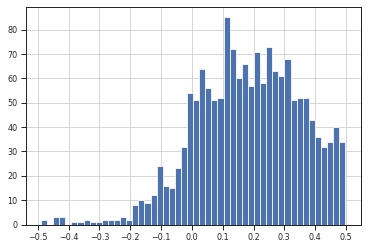

In [8]:
ax = df[(df.decomp_energy > -.5) & (df.decomp_energy < .5)].decomp_energy.hist(bins=50)
ax.set_xticks(np.arange(-.5, .6, .1))
plt.show()

<AxesSubplot:>

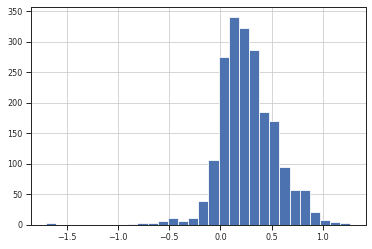

In [9]:
df.decomp_energy.hist(bins=30)

## Double check the decomposition for some structures

In [10]:
def setup_competing_phases(competing_phases_files):
    if not isinstance(competing_phases_files, list):
        competing_phases_files = [competing_phases_files]
    all_competing_phases = [load_competing_phases(f) for f in competing_phases_files]

    # also add the individual elements
    competing_phases = pd.concat([pd.Series(fere_entries)] + all_competing_phases).reset_index()[0]
    return competing_phases


def load_competing_phases(competing_phases_file):
    print(f"Reading {competing_phases_file}")
    df = pd.read_csv(competing_phases_file)
    print(f"\t{len(df)} lines")
    print(df.head(2))

    assert ('sortedformula' in df.columns or 'comp' in df.columns) \
        and ('energyperatom' in df.columns or 'predicted_energy' in df.columns)
    if 'sortedformula' not in df.columns:
        df.rename(columns={'comp': 'sortedformula'}, inplace=True)
    if 'energyperatom' not in df.columns:
        df.rename(columns={'predicted_energy': 'energyperatom'}, inplace=True)
    print("columns after renaming:", df.columns)

    df['energy'] = (
        df.energyperatom *
        df.sortedformula.apply(lambda x: Composition(x).num_atoms)
    )
    # convert the dataframe to a list of PDEntries used to create the convex hull
    pd_entries = df.apply(
        lambda row: PDEntry(Composition(row.sortedformula),
                            row.energy),
        axis=1
    )
    print(f"\t{len(pd_entries)} entries")
    return pd_entries

In [11]:
competing_phases_files = [
    "/projects/rlmolecule/jlaw/rlmolecule/examples/crystal_energy/inputs/competing_phases.csv",
    "/projects/rlmolecule/jlaw/crystal_outputs/2022-07-05/best_decor_rewards.csv.gz",
]

In [12]:
competing_phases = setup_competing_phases(competing_phases_files)

Reading /projects/rlmolecule/jlaw/rlmolecule/examples/crystal_energy/inputs/competing_phases.csv
	12682 lines
  sortedformula   icsdnum  energyperatom reduced_composition
0    Ag10Br3Te4  173116.0      -1.718985          Ag10Br3Te4
1   Ag11K1O16V4  391344.0      -4.797702         Ag11K1O16V4
columns after renaming: Index(['sortedformula', 'icsdnum', 'energyperatom', 'reduced_composition'], dtype='object')
	12682 entries
Reading /projects/rlmolecule/jlaw/crystal_outputs/2022-07-05/best_decor_rewards.csv.gz
	2003 lines
                       id      comp    reward  predicted_energy  \
0  Li3Y1Br6_icsd_053533_1  Li3Y1Br6  1.135173         -3.798492   
1  Li4Y1Br7_icsd_001322_1  Li4Y1Br7  1.132112         -3.735198   

   decomp_energy  cond_ion_frac  reduction  oxidation  stability_window  
0        -0.8512         0.3000    -0.6734       -5.0            4.3266  
1        -0.7266         0.3333    -0.6045       -5.0            4.3955  
columns after renaming: Index(['id', 'sortedformula',

In [19]:
competing_phases[100]

PDEntry : Ag1 Bi1 K2 with energy = -8.3651

In [13]:
df[df.decor_id == "Li1Ge1O1N1|_1_1_1_1|orthorhombic|icsd_183047|2"]

,decor_id,reward,predicted_energy,decomp_energy,cond_ion_frac,reduction,oxidation,stability_window
787,Li1Ge1O1N1|_1_1_1_1|orthorhombic|icsd_183047|2,0.312,-6.131,0.0,0.25,NaN,NaN,NaN


In [14]:
comp = Composition("Li1Ge1O1N1")
entry = PDEntry(comp, -24.524)
entry

PDEntry : Li1 Ge1 O1 N1 with energy = -24.5240

In [15]:
elements = set(comp.elements)
curr_entries = [e for e in competing_phases if len(set(e.composition.elements) - elements) == 0
                             and e != entry]
curr_entries

[PDEntry : Ge1 with energy = -4.3400,
 PDEntry : Li1 with energy = -1.5800,
 PDEntry : N1 with energy = -8.4600,
 PDEntry : O1 with energy = -4.8000,
 PDEntry : Ge1 Li1 with energy = -7.0905,
 PDEntry : Ge1 O2 with energy = -19.4096,
 PDEntry : Ge2 Li7 with energy = -25.4758,
 PDEntry : Ge3 N4 with energy = -47.5349,
 PDEntry : Ge4 Li15 with energy = -53.3199,
 PDEntry : Ge4 Li9 with energy = -40.0625,
 PDEntry : Ge6 Li11 with energy = -54.2760,
 PDEntry : Li1 N1 with energy = -10.8040,
 PDEntry : Li3 N1 with energy = -15.5342,
 PDEntry : Ge2 N2 O1 with energy = -33.5677,
 PDEntry : Li1 N1 O3 with energy = -29.1773,
 PDEntry : N2 O4 with energy = -35.9692,
 PDEntry : N2 O1 with energy = -16.1545,
 PDEntry : N2 O3 with energy = -30.1289,
 PDEntry : N2 O5 with energy = -40.6163,
 PDEntry : Li2 O1 with energy = -14.3010,
 PDEntry : Li4 Ge1 O4 with energy = -50.3342,
 PDEntry : Li5 Ge1 N3 with energy = -43.3063,
 PDEntry : Li2 Ge1 O3 with energy = -35.2300,
 PDEntry : Li6 Ge2 O7 with energ

In [23]:
phase_diagram = PhaseDiagram(curr_entries, elements=elements)

In [24]:
decomp, decomp_energy = phase_diagram.get_decomp_and_e_above_hull(
    entry,
    allow_negative=True,
    # docs say: "if you have a huge proportion of unstable entries,
    # then this check can slow things down."
    check_stable=False)

In [18]:
print(comp, decomp_energy)
decomp

Li1 Ge1 O1 N1 -0.0005213794708254227


{PDEntry : Li2 Ge1 O3 with energy = -35.2300: 0.5,
 PDEntry : Li1 Ge2 N3 with energy = -38.3358: 0.5}